# Posterior Network: Uncertainty Estimation without OOD Samples via Density-Based Pseudo-Counts

Posterior Networks (PostNet) extend the idea of Evidential Deep Learning (EDL) by producing a full Dirichlet distribution over class probabilities for each input. However, instead of evidence being directly predicted by the neural network, PostNet does so by deriving evidence from class-conditional density estimates in a latent space. This assures that out-of-distribution (OOD) samples are not needed during training, as uncertainty increases for inputs that lie outside the learned density.

In this notebook, we will:
- Build a small encoder to map inputs into a latent space
- Train a single batched radial flow that models all class-conditional densities
- Convert densities into evidence (Dirichlet pseudo-counts) and train with a unified evidential trainer
- Evaluate accuracy and plot epistemic evidence for in-distribution (ID) and OOD data


## Imports and Setup

In [ ]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import Tensor, nn
from torch.distributions import Dirichlet
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as T

from probly.layers.evidential import torch as t
from probly.losses.evidential.torch import postnet_loss
import probly.models.evidential.torch as m
from probly.train.evidential.torch import unified_evidential_train

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data Preparation

Posterior Networks require:
- an ID dataset used for training and standard evaluation
- an OOD dataset used only for testing epistemic uncertainty

Here, we use **MNIST** as the ID dataset and **FashionMNIST** as the OOD dataset

In [2]:
transform = T.transforms.Compose(
    [
        T.transforms.ToTensor(),
        T.transforms.Normalize((0.5,), (0.5,)),
    ],
)

train_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=True,
    download=True,
    transform=transform,
)
test_data = torchvision.datasets.MNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)
ood_data = torchvision.datasets.FashionMNIST(
    root="~/datasets",
    train=False,
    download=True,
    transform=transform,
)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256, shuffle=False)
ood_loader = DataLoader(ood_data, batch_size=256, shuffle=False)

print("Loaded MNIST (ID) and FashionMNIST (OOD)")

Loaded MNIST (ID) and FashionMNIST (OOD)


## Model Definition

Posterior Networks are composed of:
1. **Encoder**: maps each image to a low-dimensional latent vector.
2. **Class-conditional normalizing flows**: instead of training one flow per class, we use a single batched radial-flow model that jointly computes all class-conditional densities P(z|c). These densities provide the evidence used to construct the Dirichlet distribution.

In [ ]:
# Encoder (x -> z)
class Encoder(nn.Module):
    def __init__(self, latent_dim=6) -> None:  # noqa: ANN001
        """Initialize encoder with a small MLP and BatchNorm."""
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
        )
        self.bn = nn.BatchNorm1d(latent_dim)

    def forward(self, x) -> torch.Tensor:  # noqa: ANN001
        """Encode a batch of images x into latent vectors z."""
        z = self.net(x)
        z = self.bn(z)
        return z


# Normalizing flows


class RadialFlowLayer(nn.Module):
    """Single radial flow transformation shared across all classes."""

    def __init__(self, num_classes: int, dim: int) -> None:
        """Initialize parameters for a radial flow transform."""
        super().__init__()
        self.c = num_classes
        self.dim = dim

        self.x0 = nn.Parameter(torch.zeros(self.c, self.dim))
        self.alpha_prime = nn.Parameter(torch.zeros(self.c))
        self.beta_prime = nn.Parameter(torch.zeros(self.c))

        self.reset_parameters()

    def reset_parameters(self) -> None:
        """Reset learnable parameters with a small uniform init."""
        stdv = 1.0 / math.sqrt(self.dim)
        self.x0.data.uniform_(-stdv, stdv)
        self.alpha_prime.data.uniform_(-stdv, stdv)
        self.beta_prime.data.uniform_(-stdv, stdv)

    def forward(self, zc) -> tuple[torch.Tensor, torch.Tensor]:  # noqa: ANN001
        """Apply the radial flow to latent inputs zc."""
        alpha = torch.nn.functional.softplus(self.alpha_prime)
        beta = -alpha + torch.nn.functional.softplus(self.beta_prime)

        x0 = self.x0.unsqueeze(1)
        diff = zc - x0
        r = diff.norm(dim=-1)

        h = 1.0 / (alpha.unsqueeze(1) + r)
        h_prime = -h * h
        beta_h = beta.unsqueeze(1) * h

        z_new = zc + beta_h.unsqueeze(-1) * diff

        term1 = (self.dim - 1) * torch.log1p(beta_h)
        term2 = torch.log1p(beta_h + beta.unsqueeze(1) * h_prime * r)
        log_abs_det = term1 + term2

        return z_new, log_abs_det


class BatchedRadialFlowDensity(nn.Module):
    """Radial-flow density estimator that computes P(z|c) for all classes."""

    def __init__(self, num_classes: int, dim: int, flow_length: int = 6) -> None:
        """Create a sequence of radial flow layers and base distribution."""
        super().__init__()
        self.c = num_classes
        self.dim = dim

        self.layers = nn.ModuleList(
            [RadialFlowLayer(num_classes, dim) for _ in range(flow_length)],
        )

        self.log_base_const = -0.5 * self.dim * math.log(2 * math.pi)

    def forward(self, x) -> tuple[torch.Tensor, torch.Tensor]:  # noqa: ANN001
        """Expand input x for all classes and apply flow layers."""
        B = x.size(0)  # noqa: N806
        zc = x.unsqueeze(0).expand(self.c, B, self.dim)
        sum_log_jac = torch.zeros(self.c, B, device=x.device)

        for layer in self.layers:
            zc, log_j = layer(zc)
            sum_log_jac = sum_log_jac + log_j

        return zc, sum_log_jac

    def log_prob(self, x) -> torch.Tensor:  # noqa: ANN001
        """Return class-conditional log densities log P(x|c)."""
        zc, sum_log_jac = self.forward(x)  # zc: [C,B,D]

        base_logp = self.log_base_const - 0.5 * (zc**2).sum(dim=-1)
        logp = base_logp + sum_log_jac  # [C,B]

        return logp.transpose(0, 1)  # [B,C]

## PostNet Loss Function

In [ ]:
def postnet_loss2(
    z: Tensor,
    y: Tensor,
    flow: t.BatchedRadialFlowDensity,
    class_counts: Tensor,
    entropy_weight: float = 1e-5,
) -> torch.Tensor:
    """Posterior Networks (PostNet) loss."""
    log_dens = flow.log_prob(z)  # [B,C]
    dens = log_dens.exp()

    beta = dens * class_counts.unsqueeze(0)
    alpha = beta + 1.0
    alpha0 = alpha.sum(dim=1)

    digamma = torch.digamma
    batch_idx = torch.arange(len(y), device=y.device)
    expected_ce = digamma(alpha0) - digamma(alpha[batch_idx, y])

    entropy = Dirichlet(alpha).entropy()

    loss = (expected_ce - entropy_weight * entropy).mean()
    return loss, alpha

## Training Loop

In [3]:
num_classes = 10
class_counts = torch.zeros(num_classes, device=device)

for _, y in train_loader:
    y = y.to(device)  # noqa: PLW2901
    for c in range(num_classes):
        class_counts[c] += (y == c).sum()

model = m.PostNetModel()
loss = postnet_loss

unified_evidential_train(
    "PostNet",
    model,
    train_loader,
    loss,
    class_count=class_counts,
    epochs=5,
    lr=1e-3,
)

Epoch [1/5] - Loss: 1.5458
Epoch [2/5] - Loss: 0.4973
Epoch [3/5] - Loss: 0.2317
Epoch [4/5] - Loss: 0.1730
Epoch [5/5] - Loss: 0.1418


## Evaluation: Predictions & Accuracy
Compute Dirichlet posteriors and accuracy on the MNIST test set.

In [6]:
def evaluate(model, loader, class_counts) -> float:  # noqa: ANN001
    model.eval()

    correct = 0
    total = 0

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)  # noqa: PLW2901
            z = model(x)

            flow = model.flow
            log_dens = flow.log_prob(z)
            dens = log_dens.exp()
            beta = dens * class_counts.unsqueeze(0)
            alpha = beta + 1.0
            alpha0 = alpha.sum(dim=1, keepdim=True)

            probs = alpha / alpha0
            preds = probs.argmax(dim=1)

            correct += (preds == y).sum().item()
            total += len(y)

    acc = correct / total
    print(f"Accuracy: {acc:.4f}")
    return acc


evaluate(model, test_loader, class_counts)

Accuracy: 0.9628


0.9628

## Epistemic Uncertainty Extraction

Posterior Networks quantify epistemic uncertainty using the total Dirichlet evidence, defined as the sum of all Dirichlet parameters for each class. High evidence indicates high confidence (in-distribution), while low evidence indicates uncertainty. Here, we compute evidence values for MNIST and FashionMNIST samples.

Mean ID α₀: 127422.4921875
Mean OOD α₀: 22184.423828125


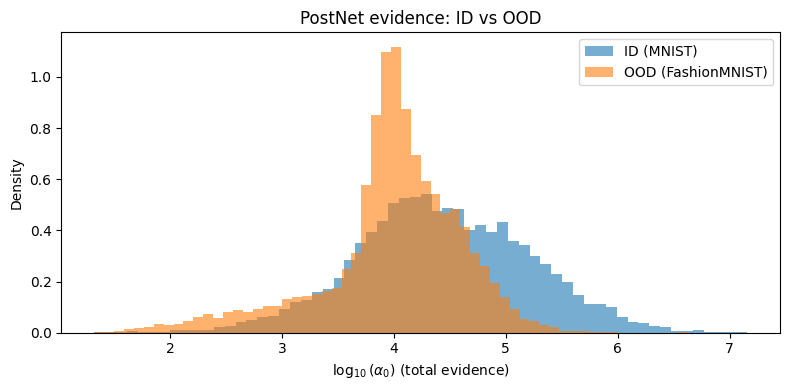

In [8]:
def compute_alpha0(model, loader, class_counts) -> torch.Tensor:  # noqa: ANN001
    model.eval()

    out = []
    with torch.no_grad():
        for x, _ in loader:
            x = x.to(device)  # noqa: PLW2901
            z = model(x)
            flow = model.flow
            log_dens = flow.log_prob(z)
            dens = log_dens.exp()
            beta = dens * class_counts.unsqueeze(0)
            alpha = beta + 1.0
            alpha0 = alpha.sum(dim=1)
            out.append(alpha0.cpu())
    return torch.cat(out)


id_alpha0 = compute_alpha0(model, test_loader, class_counts)
ood_alpha0 = compute_alpha0(model, ood_loader, class_counts)

print("Mean ID α₀:", id_alpha0.mean().item())
print("Mean OOD α₀:", ood_alpha0.mean().item())

eps = 1e-12
id_log = np.log10(id_alpha0.numpy() + eps)
ood_log = np.log10(ood_alpha0.numpy() + eps)

plt.figure(figsize=(8, 4))
plt.hist(id_log, bins=60, density=True, alpha=0.6, label="ID (MNIST)")
plt.hist(ood_log, bins=60, density=True, alpha=0.6, label="OOD (FashionMNIST)")
plt.xlabel(r"$\log_{10}(\alpha_0)$ (total evidence)")
plt.ylabel("Density")
plt.title("PostNet evidence: ID vs OOD")
plt.legend()
plt.tight_layout()
plt.show()